# Experiments on nearest neighbor approach using histogram similarity

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

tqdm.pandas()

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
SEED = 23
data_dir = Path("../Daten/data_to_use")

In [4]:
df_brasil = pd.read_json(data_dir/"brazil_gaz_train.json")
df_japan = pd.read_json(data_dir/"japan_train.json")

In [271]:
df_brasil.head()

CITY  ID  Price  cartel   Weekbegin  nbids  rank        cv  \
0  BeloHorizonte   1  1.758       1  2004-01-04    332     1  0.036899   
1  BeloHorizonte   1  1.759       1  2004-01-04    332     2  0.036899   
2  BeloHorizonte   1  1.759       1  2004-01-04    332     3  0.036899   
3  BeloHorizonte   1  1.765       1  2004-01-04    332     4  0.036899   
4  BeloHorizonte   1  1.766       1  2004-01-04    332     5  0.036899   

    spread     diffp        rd    rdnorm     rdalt      skew        ks  
0  0.29124  0.000569  0.014614  0.646484  0.645793  1.495001  5.020408  
1  0.29124  0.000569  0.014614  0.646484  0.645793  1.495001  5.020408  
2  0.29124  0.000569  0.014614  0.646484  0.645793  1.495001  5.020408  
3  0.29124  0.000569  0.014614  0.646484  0.645793  1.495001  5.020408  
4  0.29124  0.000569  0.014614  0.646484  0.645793  1.495001  5.020408

In [5]:
df_japan = df_japan[["project", "bid", "cartel"]]

In [6]:
df_brasil = df_brasil[["ID", "Price", "cartel"]]

In [7]:
df_brasil_grouped = df_brasil.groupby("ID").agg({"Price": lambda x: list(((x - np.mean(x)) / np.std(x))), "cartel": lambda x: x.head(1)}).reset_index()

In [8]:
df_japan_grouped = df_japan.groupby("project").agg({"bid": lambda x: list(((x - np.mean(x)) / np.std(x))), "cartel": lambda x: x.head(1)}).reset_index()

In [35]:
df_japan_grouped.head()

project                                                bid  cartel
0        2  [-1.0202150113177961, -0.8048977059322044, -0....       1
1        3  [-1.3959390819899267, -1.3706068103247986, -1....       1
2        4  [-2.3365076302269583, -0.6451444403558858, -0....       1
3        5  [-1.5022537530662936, -1.15410688097677, -0.63...       1
4        7  [-2.0281341281001213, -1.3565665360139882, -0....       1

In [275]:
nocartel_bid_brasil = []
for i in range(len(df_brasil_grouped[df_brasil_grouped.cartel == 0])):
    nocartel_bid_brasil = nocartel_bid_brasil + df_brasil_grouped[df_brasil_grouped.cartel == 0].Price.tolist()[0]
cartel_bid_brasil = []
for i in range(len(df_brasil_grouped[df_brasil_grouped.cartel == 1])):
    cartel_bid_brasil = cartel_bid + df_brasil_grouped[df_brasil_grouped.cartel == 1].Price.tolist()[0]

In [70]:
nocartel_bid = []
for i in range(len(df_japan_grouped[df_japan_grouped.cartel == 0])):
    nocartel_bid = nocartel_bid + df_japan_grouped[df_japan_grouped.cartel == 0].bid.tolist()[0]

4710

In [72]:
cartel_bid = []
for i in range(len(df_japan_grouped[df_japan_grouped.cartel == 1])):
    cartel_bid = cartel_bid + df_japan_grouped[df_japan_grouped.cartel == 1].bid.tolist()[0]

In [265]:
kstest(nocartel_bid, cartel_bid)

KstestResult(statistic=0.36666666666666664, pvalue=1.3685608202251842e-11)

In [75]:
print(min(cartel_bid))
print(max(cartel_bid))
print(min(nocartel_bid))
print(max(nocartel_bid))

-1.0202150113177961
1.7557339929760682
-1.9590455392665518
1.8326555044751385


Text(0, 0.5, 'standardized bid')

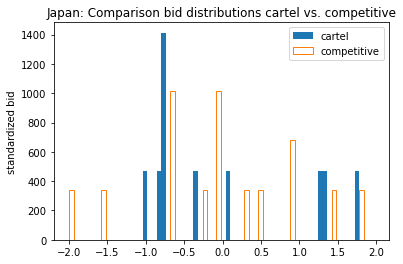

In [269]:
plt.title("Japan: Comparison bid distributions cartel vs. competitive")
mybins = np.arange(-2,2, 0.06)
plt.hist(cartel_bid,bins = mybins, label = "cartel")
plt.hist(nocartel_bid,bins = mybins, histtype = "step", label = "competitive")
plt.legend()
plt.ylabel("standardized bid")

Text(0, 0.5, 'standardized bid')

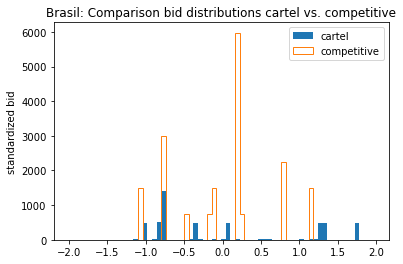

In [276]:
plt.title("Brasil: Comparison bid distributions cartel vs. competitive")
mybins = np.arange(-2,2, 0.06)
plt.hist(cartel_bid_brasil,bins = mybins, label = "cartel")
plt.hist(nocartel_bid_brasil,bins = mybins, histtype = "step", label = "competitive")
plt.legend()
plt.ylabel("standardized bid")

Text(0, 0.5, 'standardized bid')

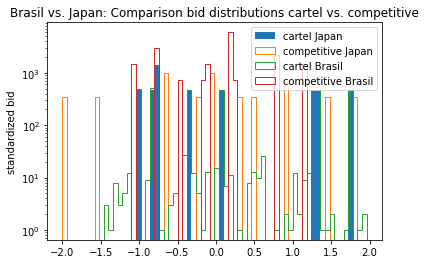

In [279]:
plt.title("Brasil vs. Japan: Comparison bid distributions cartel vs. competitive")
mybins = np.arange(-2,2, 0.06)
plt.hist(cartel_bid,bins = mybins, label = "cartel Japan")
plt.hist(nocartel_bid,bins = mybins, histtype = "step", label = "competitive Japan")
plt.hist(cartel_bid_brasil,bins = mybins,histtype = "step", label = "cartel Brasil")
plt.hist(nocartel_bid_brasil,bins = mybins, histtype = "step", label = "competitive Brasil")
plt.legend()
plt.yscale("log")
plt.ylabel("standardized bid")

# Use Kolmogorov-Smirnov to  calculate similarity between distributions

In [18]:
from scipy.stats import kstest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

In [147]:
df_japan_train, df_japan_test = train_test_split(df_japan_grouped, train_size=0.8, random_state = SEED,
                                                 stratify = df_japan_grouped.cartel.tolist())

In [9]:
df_brasil_train, df_brasil_test = train_test_split(df_brasil_grouped, train_size=0.8, random_state = SEED,
                                                 stratify = df_brasil_grouped.cartel.tolist())

In [12]:
X_train_brasil = df_brasil_train["Price"]
y_train_brasil = df_brasil_train["cartel"]
X_test_brasil = df_brasil_test["Price"]
y_test_brasil = df_brasil_test["cartel"]

In [148]:
X_train = df_japan_train["bid"]
y_train = df_japan_train["cartel"]
X_test = df_japan_test["bid"]
y_test = df_japan_test["cartel"]

In [149]:
X_train

559    [-1.6256784434396916, -1.1712316549082646, -0....
513    [-1.5689738785678617, -1.2923286103065266, -1....
425    [-2.926947452227894, -0.7626104932077027, -0.6...
389    [-2.742028485963496, -0.40838722131371213, -0....
256    [-2.54642923428507, -0.4341837864909936, -0.17...
                             ...                        
46     [-1.6581762234487782, -1.3920163159931156, -1....
702    [-2.6577418997867075, -0.6670208269892566, -0....
570    [-1.3785290271539044, -0.9714655304459896, -0....
743    [-1.697809391422767, -0.9607758571617234, -0.9...
139    [-2.8794967804390876, -0.15935177812088008, 0....
Name: bid, Length: 648, dtype: object

**Implement my own KNN-Classifier**

In [152]:
np.asarray(X_test.iloc[0])

array([-1.55105724, -0.7515432 , -0.7515432 , -0.35178618, -0.35178618,
       -0.19188337,  0.04797084,  0.44772786,  1.64699893,  1.80690174])

In [13]:
import math
from sklearn.metrics import f1_score

In [14]:
def kstest_metric(x,y):
    return kstest(x,y)[0]

In [15]:
def ClassifierAlternative(X_train, y_train, X_test, y_test):
    y_predicted = np.zeros(len(y_test))
    for i in tqdm(range(len(X_test))):
        dist_cartel = kstest_metric(np.asarray(X_test.iloc[i]), cartel_bid)
        dist_comp = kstest_metric(np.asarray(X_test.iloc[i]), nocartel_bid)      
        y_predicted[i] = 1 if (dist_comp < dist_cartel) else 0

    return y_predicted

In [16]:
def KNNClassifier(X_train, y_train, X_test, y_test, k = 5):
    y_predicted = np.zeros(len(y_test))
    for i in tqdm(range(len(X_test))):
        dist = np.zeros(len(X_train))
        for j in range(len(X_train)):
            dist[j] = kstest_metric(np.asarray(X_test.iloc[i]), np.asarray(X_train.iloc[j]))
        ind = np.argsort(dist)[:k]
        #print(dist[ind.astype(int)])
        y_predicted[i] = 0 if (np.asarray(y_train.iloc[ind.astype(int)].tolist()).sum()<math.ceil(k/2)) else 1
    return y_predicted

In [263]:
y_pred_alt = ClassifierAlternative(X_train, y_train, X_test, y_test)
F1_alt = f1_score(y_test, y_pred_alt)
print(F1_alt)

  0%|          | 0/162 [00:00<?, ?it/s]

0.6926406926406925


In [260]:
y_pred_alt = ClassifierAlternative(X_train, y_train, X_test, y_test)
F1_alt = f1_score(y_test, y_pred_alt)
print(F1_alt)

  0%|          | 0/162 [00:00<?, ?it/s]

0.6926406926406925


In [196]:
y_pred = KNNClassifier(X_train, y_train, X_test, y_test, k=13)
F1 = f1_score(y_test, y_pred)
print(F1)

  0%|          | 0/162 [00:00<?, ?it/s]

0.7177033492822966


In [21]:
y_pred_brasil = KNNClassifier(X_train_brasil, y_train_brasil, X_test_brasil, y_test_brasil, k=13)
F1 = f1_score(y_test_brasil, y_pred_brasil)
print(F1)

  0%|          | 0/288 [00:00<?, ?it/s]

0.5562913907284769


## These things didn't work

In [106]:
configuration = [
    ('Dummy', DummyClassifier(), {'Dummy__strategy' : ["stratified"]}),
    ('KNN', KNeighborsClassifier(), {'KNN__metric': [kstest_metric]})
]

In [107]:
model_scores = []
models = []
for name, algo, params in configuration:
    print(f'Trying {name} ...')
    # Extend model with normalisation step (here we use z-normalisation)
    #pipeline = Pipeline([("scaler", StandardScaler()), (name, algo)])
    pipeline=Pipeline([(name, algo)])
    # Instantiate grid search object and pass params, number of folds and scoring-function
    classifier = GridSearchCV(pipeline, param_grid=params, cv=10, scoring='f1')
    # Fit cross validation to our training data: within this function, all configurations are tried
    classifier.fit(X, y)
    print(f'  - Best hyperparameter: {classifier.best_params_}')
    print(f'  - Best F1 score: {classifier.best_score_:.3f}')
    print(f'  - F1 Result for each parametrization:', [f'{x:.2f}' for x in classifier.cv_results_['mean_test_score']])
    
    model_scores.append(classifier.best_score_)
    models.append(classifier.best_estimator_)

Trying Dummy ...
  - Best hyperparameter: {'Dummy__strategy': 'stratified'}
  - Best F1 score: 0.576
  - F1 Result for each parametrization: ['0.58']
Trying KNN ...


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
TypeError: float() argument must be a string or a number, not 'list'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._f

ValueError: setting an array element with a sequence.

In [102]:
neigh = KNeighborsClassifier(metric = kstest_metric)

# Thoughts on Cartel Detection with Kolmogorov Smironv Test

...should definitely work better. Especially looking at japan data. Perhpas KS is not the right tool.

# Try it with Clustering

In [296]:
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans

Spectral Clustering has been chosen, because it works on Medium n_samples and small n_clusters, whatever small, medium and large means. I don't consider my dataset to be large, what would be used for K means Clustering

Make the whole array flat:

In [ ]:
df_japan_train, df_japan_test 

In [290]:
df_japan_train.bid.iloc[0]

[-1.6256784434396916,
 -1.1712316549082646,
 -0.5525269910040329,
 -0.540663922227108,
 -0.29701474042411413,
 0.3105568897048498,
 0.5242746364399105,
 0.6155290116470242,
 0.7341596994162722,
 2.0025955147951544]

In [291]:
X_train = []
for i in range(len(df_japan_train)):
    X_train = X_train +df_japan_train.bid.iloc[i]


In [299]:
X_train = np.array(X_train).reshape(-1,1)

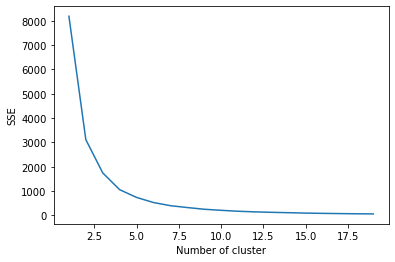

In [302]:
sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X_train)
    #X_train["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

Have been tricked: Clusters are only obvious if the colors (e.g. labels are there). Therefore switch to Classification.

# Back to Classification

In [307]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

In [320]:
df_japan_grouped = df_japan.groupby("project").agg({"bid": lambda x: list(((x - np.mean(x)) / np.std(x))), "cartel": lambda x: x.head(1)}).reset_index()

In [324]:
df_japan_grouped = df_japan_grouped.explode(["bid"])

In [333]:
features = ["bid"]

In [334]:
X = df_japan_grouped[features]
y = df_japan_grouped["cartel"]

In [335]:
X

bid
0   -1.020215
0   -0.804898
0   -0.781038
0   -0.754621
0   -0.751037
..        ...
809  -0.14788
809 -0.106474
809 -0.009859
809 -0.009859
809  3.537299

[10185 rows x 1 columns]

With a random tree!

In [339]:
configuration = [
    ('Dummy', DummyClassifier(), {'Dummy__strategy' : ["stratified"]}),
    ('Tree', DecisionTreeClassifier(), {'Tree__max_depth': range(1,20), 'Tree__random_state': [SEED]}),
]

In [340]:
model_scores = []
models = []
for name, algo, params in configuration:
    print(f'Trying {name} ...')
    # Extend model with normalisation step (here we use z-normalisation)
    pipeline = Pipeline([(name, algo)])
    # Instantiate grid search object and pass params, number of folds and scoring-function
    classifier = GridSearchCV(pipeline, param_grid=params, cv=10, scoring='f1')
    # Fit cross validation to our training data: within this function, all configurations are tried
    classifier.fit(X, y)
    print(f'  - Best hyperparameter: {classifier.best_params_}')
    print(f'  - Best F1 score: {classifier.best_score_:.3f}')
    print(f'  - F1 Result for each parametrization:', [f'{x:.2f}' for x in classifier.cv_results_['mean_test_score']])
    
    model_scores.append(classifier.best_score_)
    models.append(classifier.best_estimator_)

Trying Dummy ...
  - Best hyperparameter: {'Dummy__strategy': 'stratified'}
  - Best F1 score: 0.494
  - F1 Result for each parametrization: ['0.49']
Trying Tree ...
  - Best hyperparameter: {'Tree__max_depth': 2, 'Tree__random_state': 23}
  - Best F1 score: 0.582
  - F1 Result for each parametrization: ['0.25', '0.58', '0.58', '0.56', '0.56', '0.56', '0.56', '0.56', '0.56', '0.55', '0.56', '0.56', '0.56', '0.56', '0.56', '0.55', '0.55', '0.55', '0.55']
